In [77]:
import os

import itertools
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

%matplotlib inline

In [78]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchtext
from torch.autograd import Variable as V
import spacy
 
from spacy.symbols import ORTH
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [79]:
grad_clip = 0.1
lr = 4.
best_val_loss = None
log_interval = 100
batch_size = 128
eval_batch_size = 128
sequence_length = 30

In [80]:
class RNNModel(nn.Module):
    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModel, self).__init__()

        self.rnn_type, self.nhid, self.nlayers = rnn_type, nhid, nlayers

        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(ninp, nhid, nlayers, dropout=dropout)
        else:
            assert False, "invalid mode: " + rnn_type
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x, hidden=None):
        emb = self.drop(self.encoder(x))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        if self.rnn_type == 'LSTM':
            return (V(weight.new(self.nlayers, bsz, self.nhid).zero_().cuda()),
                    V(weight.new(self.nlayers, bsz, self.nhid).zero_()).cuda())
        else:
            return V(weight.new(self.nlayers, bsz, self.nhid).zero_().cuda())

In [81]:
from torchtext.data.utils import get_tokenizer

def tok(x):
    return [sym for sym in x]

TEXT = torchtext.data.Field(tokenize=tok)

# make splits for data
train, valid, test = torchtext.datasets.WikiText2.splits(TEXT)

# build the vocabulary
TEXT.build_vocab(train, vectors="glove.6B.200d")

# make iterator for splits
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_iter, valid_iter, test_iter = torchtext.data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=batch_size,
    bptt_len=sequence_length,
    device=device,
    repeat=False)

weight_matrix = TEXT.vocab.vectors
ntokens = weight_matrix.size(0)

criterion = nn.CrossEntropyLoss()

In [82]:
def evaluate(model, iter):
    model.eval()
    total_loss = 0
    hidden = model.init_hidden(eval_batch_size)
    for batch in tqdm(iter):
        text, targets = batch.text, batch.target
        targets = targets.view(-1)
        output, hidden = model(text)
        output_flat = output.view(-1, ntokens)
        total_loss += criterion(output_flat, targets).item()
    return total_loss / len(iter) if len(iter) != 0 else 0

In [83]:
def train(model):
    model.train()
    total_loss = 0
    batch_num = 0
    for batch in tqdm(train_iter):
        text, targets = batch.text, batch.target
        targets = targets.view(-1)
        model.zero_grad()
        output, hidden = model(text)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        for p in model.parameters():
            p.data.add_(-lr, p.grad.data)

        total_loss += loss.item()

        if batch_num % log_interval == 0 and batch_num > 0:
            cur_loss = total_loss / log_interval
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch_num, len(train_iter), lr, cur_loss, math.exp(cur_loss)))
            total_loss = 0
        batch_num += 1
        

In [84]:
def generate(model, n=50, temp=1.):
    model.eval()
    x = torch.rand(1, 1).mul(ntokens).long().to(device=device)
    out = []
    for i in range(n):
        output, hidden = model(x)
        s_weights = output.squeeze().data.div(temp).exp()
        s_idx = torch.multinomial(s_weights, 1)[0]
        x.data.fill_(s_idx)
        s = TEXT.vocab.itos[s_idx]
        out.append(s)
    return ''.join(out)

In [91]:
def plot_ppl(log):
    keys = log.keys()
    logs = {k:[z for z in zip(log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    handlers, = zip(*[plt.plot(epochs[k], logs[k], label=k) for k in keys])
    plt.title('ppl')
    plt.xlabel('epoch')
    plt.ylabel('ppl')
    plt.legend(handles=handlers)
    plt.show()


In [86]:
models = {'LSTM2' : RNNModel('LSTM', weight_matrix.size(0), weight_matrix.size(1), 200, 2, 0.3),
          'GRU2' : RNNModel('GRU', weight_matrix.size(0), weight_matrix.size(1), 200, 2, 0.3),
          'LSTM5' : RNNModel('LSTM', weight_matrix.size(0), weight_matrix.size(1), 200, 5, 0.3),
          'GRU5' : RNNModel('GRU', weight_matrix.size(0), weight_matrix.size(1), 200, 5, 0.3)}

eval_log = {key: [] for key in models}
for key, model in models.items():
    model.encoder.weight.data.copy_(weight_matrix)
    model.cuda()

    with torch.no_grad():
        print('sample:\n', generate(model, 50), '\n')

    for epoch in range(1, 6):
        train(model)
        val_loss = evaluate(model, valid_iter)
        ppl = math.exp(val_loss)
        eval_log[key].append(ppl)

        print('-' * 89)
        print('| end of epoch {:3d} | valid loss {:5.2f} | valid ppl {:8.2f}'.format(
            epoch, val_loss, ppl))
        print('-' * 89)
        if not best_val_loss or val_loss < best_val_loss:
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 4.0
        with torch.no_grad():
            print('sample:\n', generate(model, 50), '\n')

    t1 = generate(model, 10000, 1.)
    t15 = generate(model, 10000, 1.5)
    t075 = generate(model, 10000, 0.75)
    with open('./generated075-' + key + '.txt', 'w') as outf:
        outf.write(t075)
    with open('./generated1-' + key + '.txt', 'w') as outf:
        outf.write(t1)
    with open('./generated15-' + key + '.txt', 'w') as outf:
        outf.write(t15)



  0%|          | 0/2808 [00:00<?, ?it/s]

sample:
 ♯ć・ვト!キgr5m§ÖäنšCზ5úy<ั–5„ỳ.ãზ'>àÖ½งоŁûè\đäử²>^"κI 




  4%|▍         | 112/2808 [00:02<02:05, 21.56it/s]

| epoch   1 |   100/ 2808 batches | lr 4.00 | loss  3.57 | ppl    35.43



  8%|▊         | 219/2808 [00:03<00:27, 93.28it/s]

| epoch   1 |   200/ 2808 batches | lr 4.00 | loss  3.19 | ppl    24.40



 11%|█▏        | 320/2808 [00:04<00:22, 108.42it/s]

| epoch   1 |   300/ 2808 batches | lr 4.00 | loss  2.98 | ppl    19.68



 15%|█▍        | 413/2808 [00:05<00:21, 109.97it/s]

| epoch   1 |   400/ 2808 batches | lr 4.00 | loss  2.81 | ppl    16.62



 18%|█▊        | 518/2808 [00:06<00:20, 110.09it/s]

| epoch   1 |   500/ 2808 batches | lr 4.00 | loss  2.70 | ppl    14.81



 22%|██▏       | 612/2808 [00:06<00:19, 110.68it/s]

| epoch   1 |   600/ 2808 batches | lr 4.00 | loss  2.57 | ppl    13.10



 25%|██▌       | 715/2808 [00:07<00:19, 109.24it/s]

| epoch   1 |   700/ 2808 batches | lr 4.00 | loss  2.47 | ppl    11.84



 29%|██▉       | 816/2808 [00:08<00:18, 108.72it/s]

| epoch   1 |   800/ 2808 batches | lr 4.00 | loss  2.40 | ppl    11.01



 33%|███▎      | 922/2808 [00:09<00:17, 109.50it/s]

| epoch   1 |   900/ 2808 batches | lr 4.00 | loss  2.34 | ppl    10.38



 36%|███▌      | 1012/2808 [00:10<00:16, 109.51it/s]

| epoch   1 |  1000/ 2808 batches | lr 4.00 | loss  2.29 | ppl     9.85



 40%|███▉      | 1115/2808 [00:11<00:15, 108.90it/s]

| epoch   1 |  1100/ 2808 batches | lr 4.00 | loss  2.24 | ppl     9.37



 43%|████▎     | 1217/2808 [00:12<00:14, 109.57it/s]

| epoch   1 |  1200/ 2808 batches | lr 4.00 | loss  2.20 | ppl     9.07



 47%|████▋     | 1319/2808 [00:13<00:13, 108.84it/s]

| epoch   1 |  1300/ 2808 batches | lr 4.00 | loss  2.17 | ppl     8.79



 50%|█████     | 1412/2808 [00:14<00:12, 110.02it/s]

| epoch   1 |  1400/ 2808 batches | lr 4.00 | loss  2.14 | ppl     8.49



 54%|█████▍    | 1516/2808 [00:15<00:11, 109.75it/s]

| epoch   1 |  1500/ 2808 batches | lr 4.00 | loss  2.12 | ppl     8.33



 58%|█████▊    | 1619/2808 [00:16<00:10, 109.42it/s]

| epoch   1 |  1600/ 2808 batches | lr 4.00 | loss  2.10 | ppl     8.14



 61%|██████    | 1713/2808 [00:16<00:10, 109.25it/s]

| epoch   1 |  1700/ 2808 batches | lr 4.00 | loss  2.07 | ppl     7.95



 65%|██████▍   | 1819/2808 [00:17<00:08, 110.48it/s]

| epoch   1 |  1800/ 2808 batches | lr 4.00 | loss  2.06 | ppl     7.81



 68%|██████▊   | 1915/2808 [00:18<00:08, 109.83it/s]

| epoch   1 |  1900/ 2808 batches | lr 4.00 | loss  2.04 | ppl     7.71



 72%|███████▏  | 2023/2808 [00:19<00:07, 110.64it/s]

| epoch   1 |  2000/ 2808 batches | lr 4.00 | loss  2.02 | ppl     7.52



 75%|███████▌  | 2119/2808 [00:20<00:06, 111.86it/s]

| epoch   1 |  2100/ 2808 batches | lr 4.00 | loss  2.01 | ppl     7.45



 79%|███████▉  | 2215/2808 [00:21<00:05, 111.12it/s]

| epoch   1 |  2200/ 2808 batches | lr 4.00 | loss  1.99 | ppl     7.34



 83%|████████▎ | 2323/2808 [00:22<00:04, 110.54it/s]

| epoch   1 |  2300/ 2808 batches | lr 4.00 | loss  1.99 | ppl     7.30



 86%|████████▌ | 2419/2808 [00:23<00:03, 110.03it/s]

| epoch   1 |  2400/ 2808 batches | lr 4.00 | loss  1.96 | ppl     7.13



 90%|████████▉ | 2520/2808 [00:24<00:02, 108.81it/s]

| epoch   1 |  2500/ 2808 batches | lr 4.00 | loss  1.96 | ppl     7.08



 93%|█████████▎| 2619/2808 [00:25<00:01, 107.71it/s]

| epoch   1 |  2600/ 2808 batches | lr 4.00 | loss  1.95 | ppl     7.00



 97%|█████████▋| 2721/2808 [00:26<00:00, 109.68it/s]

| epoch   1 |  2700/ 2808 batches | lr 4.00 | loss  1.94 | ppl     6.94



100%|██████████| 2808/2808 [00:26<00:00, 104.15it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   1 |  2800/ 2808 batches | lr 4.00 | loss  1.91 | ppl     6.79



100%|██████████| 292/292 [00:00<00:00, 398.55it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   1 | valid loss  1.73 | valid ppl     5.63
-----------------------------------------------------------------------------------------
sample:
 nglul hif . " to āilipo cen f " tit , of thedealit 




  4%|▍         | 116/2808 [00:02<02:03, 21.81it/s]

| epoch   2 |   100/ 2808 batches | lr 4.00 | loss  1.93 | ppl     6.89



  8%|▊         | 222/2808 [00:03<00:27, 94.73it/s]

| epoch   2 |   200/ 2808 batches | lr 4.00 | loss  1.90 | ppl     6.66



 11%|█▏        | 318/2808 [00:04<00:22, 109.04it/s]

| epoch   2 |   300/ 2808 batches | lr 4.00 | loss  1.89 | ppl     6.62



 15%|█▍        | 414/2808 [00:05<00:21, 110.50it/s]

| epoch   2 |   400/ 2808 batches | lr 4.00 | loss  1.88 | ppl     6.57



 19%|█▊        | 522/2808 [00:06<00:20, 110.74it/s]

| epoch   2 |   500/ 2808 batches | lr 4.00 | loss  1.87 | ppl     6.52



 22%|██▏       | 618/2808 [00:06<00:19, 111.21it/s]

| epoch   2 |   600/ 2808 batches | lr 4.00 | loss  1.87 | ppl     6.46



 25%|██▌       | 713/2808 [00:07<00:19, 109.97it/s]

| epoch   2 |   700/ 2808 batches | lr 4.00 | loss  1.86 | ppl     6.43



 29%|██▉       | 820/2808 [00:08<00:18, 110.39it/s]

| epoch   2 |   800/ 2808 batches | lr 4.00 | loss  1.85 | ppl     6.37



 33%|███▎      | 915/2808 [00:09<00:16, 111.56it/s]

| epoch   2 |   900/ 2808 batches | lr 4.00 | loss  1.85 | ppl     6.35



 36%|███▋      | 1021/2808 [00:10<00:16, 109.41it/s]

| epoch   2 |  1000/ 2808 batches | lr 4.00 | loss  1.84 | ppl     6.31



 40%|███▉      | 1115/2808 [00:11<00:15, 110.34it/s]

| epoch   2 |  1100/ 2808 batches | lr 4.00 | loss  1.83 | ppl     6.24



 43%|████▎     | 1220/2808 [00:12<00:14, 109.19it/s]

| epoch   2 |  1200/ 2808 batches | lr 4.00 | loss  1.83 | ppl     6.25



 47%|████▋     | 1314/2808 [00:13<00:13, 109.59it/s]

| epoch   2 |  1300/ 2808 batches | lr 4.00 | loss  1.82 | ppl     6.19



 51%|█████     | 1421/2808 [00:14<00:12, 110.89it/s]

| epoch   2 |  1400/ 2808 batches | lr 4.00 | loss  1.80 | ppl     6.08



 54%|█████▍    | 1514/2808 [00:15<00:11, 110.15it/s]

| epoch   2 |  1500/ 2808 batches | lr 4.00 | loss  1.81 | ppl     6.09



 58%|█████▊    | 1622/2808 [00:16<00:10, 110.83it/s]

| epoch   2 |  1600/ 2808 batches | lr 4.00 | loss  1.81 | ppl     6.09



 61%|██████    | 1718/2808 [00:16<00:09, 110.66it/s]

| epoch   2 |  1700/ 2808 batches | lr 4.00 | loss  1.80 | ppl     6.04



 65%|██████▍   | 1814/2808 [00:17<00:09, 109.73it/s]

| epoch   2 |  1800/ 2808 batches | lr 4.00 | loss  1.79 | ppl     6.01



 68%|██████▊   | 1921/2808 [00:18<00:08, 110.04it/s]

| epoch   2 |  1900/ 2808 batches | lr 4.00 | loss  1.80 | ppl     6.03



 72%|███████▏  | 2017/2808 [00:19<00:07, 110.70it/s]

| epoch   2 |  2000/ 2808 batches | lr 4.00 | loss  1.78 | ppl     5.95



 75%|███████▌  | 2113/2808 [00:20<00:06, 111.17it/s]

| epoch   2 |  2100/ 2808 batches | lr 4.00 | loss  1.79 | ppl     5.98



 79%|███████▉  | 2221/2808 [00:21<00:05, 111.17it/s]

| epoch   2 |  2200/ 2808 batches | lr 4.00 | loss  1.78 | ppl     5.92



 82%|████████▏ | 2316/2808 [00:22<00:04, 109.05it/s]

| epoch   2 |  2300/ 2808 batches | lr 4.00 | loss  1.78 | ppl     5.93



 86%|████████▋ | 2423/2808 [00:23<00:03, 110.57it/s]

| epoch   2 |  2400/ 2808 batches | lr 4.00 | loss  1.76 | ppl     5.83



 90%|████████▉ | 2519/2808 [00:24<00:02, 111.17it/s]

| epoch   2 |  2500/ 2808 batches | lr 4.00 | loss  1.76 | ppl     5.83



 93%|█████████▎| 2615/2808 [00:24<00:01, 110.86it/s]

| epoch   2 |  2600/ 2808 batches | lr 4.00 | loss  1.77 | ppl     5.85



 97%|█████████▋| 2723/2808 [00:25<00:00, 110.63it/s]

| epoch   2 |  2700/ 2808 batches | lr 4.00 | loss  1.76 | ppl     5.83



100%|██████████| 2808/2808 [00:26<00:00, 104.94it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   2 |  2800/ 2808 batches | lr 4.00 | loss  1.74 | ppl     5.73



100%|██████████| 292/292 [00:00<00:00, 401.66it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   2 | valid loss  1.55 | valid ppl     4.72
-----------------------------------------------------------------------------------------
sample:
  Dingryacrief awar Og ớwanqumie ianthicovesuncus t 




  4%|▍         | 119/2808 [00:02<02:04, 21.59it/s]

| epoch   3 |   100/ 2808 batches | lr 4.00 | loss  1.76 | ppl     5.84



  8%|▊         | 221/2808 [00:03<00:27, 93.90it/s]

| epoch   3 |   200/ 2808 batches | lr 4.00 | loss  1.74 | ppl     5.70



 11%|█▏        | 317/2808 [00:04<00:22, 109.40it/s]

| epoch   3 |   300/ 2808 batches | lr 4.00 | loss  1.74 | ppl     5.70



 15%|█▍        | 413/2808 [00:05<00:21, 111.00it/s]

| epoch   3 |   400/ 2808 batches | lr 4.00 | loss  1.74 | ppl     5.69



 19%|█▊        | 521/2808 [00:06<00:20, 110.29it/s]

| epoch   3 |   500/ 2808 batches | lr 4.00 | loss  1.73 | ppl     5.66



 22%|██▏       | 617/2808 [00:06<00:19, 111.51it/s]

| epoch   3 |   600/ 2808 batches | lr 4.00 | loss  1.73 | ppl     5.62



 25%|██▌       | 713/2808 [00:07<00:18, 110.89it/s]

| epoch   3 |   700/ 2808 batches | lr 4.00 | loss  1.73 | ppl     5.63



 29%|██▉       | 821/2808 [00:08<00:17, 111.82it/s]

| epoch   3 |   800/ 2808 batches | lr 4.00 | loss  1.72 | ppl     5.60



 33%|███▎      | 917/2808 [00:09<00:17, 110.24it/s]

| epoch   3 |   900/ 2808 batches | lr 4.00 | loss  1.72 | ppl     5.60



 36%|███▌      | 1013/2808 [00:10<00:16, 110.34it/s]

| epoch   3 |  1000/ 2808 batches | lr 4.00 | loss  1.72 | ppl     5.58



 40%|███▉      | 1121/2808 [00:11<00:15, 109.68it/s]

| epoch   3 |  1100/ 2808 batches | lr 4.00 | loss  1.71 | ppl     5.55



 43%|████▎     | 1215/2808 [00:12<00:14, 110.60it/s]

| epoch   3 |  1200/ 2808 batches | lr 4.00 | loss  1.72 | ppl     5.58



 47%|████▋     | 1323/2808 [00:13<00:13, 110.72it/s]

| epoch   3 |  1300/ 2808 batches | lr 4.00 | loss  1.71 | ppl     5.53



 51%|█████     | 1419/2808 [00:14<00:12, 111.00it/s]

| epoch   3 |  1400/ 2808 batches | lr 4.00 | loss  1.69 | ppl     5.45



 54%|█████▍    | 1512/2808 [00:15<00:11, 109.25it/s]

| epoch   3 |  1500/ 2808 batches | lr 4.00 | loss  1.70 | ppl     5.49



 58%|█████▊    | 1617/2808 [00:15<00:10, 111.11it/s]

| epoch   3 |  1600/ 2808 batches | lr 4.00 | loss  1.70 | ppl     5.49



 61%|██████    | 1713/2808 [00:16<00:09, 110.50it/s]

| epoch   3 |  1700/ 2808 batches | lr 4.00 | loss  1.70 | ppl     5.45



 65%|██████▍   | 1821/2808 [00:17<00:08, 110.65it/s]

| epoch   3 |  1800/ 2808 batches | lr 4.00 | loss  1.70 | ppl     5.45



 68%|██████▊   | 1916/2808 [00:18<00:08, 111.46it/s]

| epoch   3 |  1900/ 2808 batches | lr 4.00 | loss  1.70 | ppl     5.50



 72%|███████▏  | 2012/2808 [00:19<00:07, 110.40it/s]

| epoch   3 |  2000/ 2808 batches | lr 4.00 | loss  1.69 | ppl     5.44



 75%|███████▌  | 2120/2808 [00:20<00:06, 109.86it/s]

| epoch   3 |  2100/ 2808 batches | lr 4.00 | loss  1.70 | ppl     5.47



 79%|███████▉  | 2214/2808 [00:21<00:05, 111.24it/s]

| epoch   3 |  2200/ 2808 batches | lr 4.00 | loss  1.69 | ppl     5.43



 83%|████████▎ | 2322/2808 [00:22<00:04, 110.80it/s]

| epoch   3 |  2300/ 2808 batches | lr 4.00 | loss  1.70 | ppl     5.45



 86%|████████▌ | 2418/2808 [00:23<00:03, 110.68it/s]

| epoch   3 |  2400/ 2808 batches | lr 4.00 | loss  1.68 | ppl     5.37



 89%|████████▉ | 2512/2808 [00:24<00:02, 108.73it/s]

| epoch   3 |  2500/ 2808 batches | lr 4.00 | loss  1.68 | ppl     5.37



 93%|█████████▎| 2613/2808 [00:24<00:01, 108.26it/s]

| epoch   3 |  2600/ 2808 batches | lr 4.00 | loss  1.69 | ppl     5.41



 97%|█████████▋| 2719/2808 [00:25<00:00, 110.95it/s]

| epoch   3 |  2700/ 2808 batches | lr 4.00 | loss  1.68 | ppl     5.39



100%|██████████| 2808/2808 [00:26<00:00, 104.93it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   3 |  2800/ 2808 batches | lr 4.00 | loss  1.67 | ppl     5.32



100%|██████████| 292/292 [00:00<00:00, 399.99it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   3 | valid loss  1.48 | valid ppl     4.38
-----------------------------------------------------------------------------------------
sample:
 themat , 1the o ff hesermall astolk> or teasury th 




  4%|▍         | 115/2808 [00:02<02:03, 21.80it/s]

| epoch   4 |   100/ 2808 batches | lr 4.00 | loss  1.69 | ppl     5.43



  8%|▊         | 222/2808 [00:03<00:27, 94.82it/s]

| epoch   4 |   200/ 2808 batches | lr 4.00 | loss  1.67 | ppl     5.30



 11%|█▏        | 318/2808 [00:04<00:22, 109.24it/s]

| epoch   4 |   300/ 2808 batches | lr 4.00 | loss  1.67 | ppl     5.32



 15%|█▍        | 414/2808 [00:05<00:21, 109.46it/s]

| epoch   4 |   400/ 2808 batches | lr 4.00 | loss  1.67 | ppl     5.32



 19%|█▊        | 522/2808 [00:06<00:20, 110.72it/s]

| epoch   4 |   500/ 2808 batches | lr 4.00 | loss  1.67 | ppl     5.30



 22%|██▏       | 618/2808 [00:06<00:19, 109.69it/s]

| epoch   4 |   600/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.28



 25%|██▌       | 713/2808 [00:07<00:19, 109.54it/s]

| epoch   4 |   700/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.28



 29%|██▉       | 819/2808 [00:08<00:17, 111.95it/s]

| epoch   4 |   800/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.26



 33%|███▎      | 915/2808 [00:09<00:17, 111.15it/s]

| epoch   4 |   900/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.26



 36%|███▋      | 1019/2808 [00:10<00:16, 110.13it/s]

| epoch   4 |  1000/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.25



 40%|███▉      | 1115/2808 [00:11<00:15, 112.06it/s]

| epoch   4 |  1100/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.23



 43%|████▎     | 1219/2808 [00:12<00:14, 109.10it/s]

| epoch   4 |  1200/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.27



 47%|████▋     | 1322/2808 [00:13<00:13, 110.17it/s]

| epoch   4 |  1300/ 2808 batches | lr 4.00 | loss  1.65 | ppl     5.23



 50%|█████     | 1418/2808 [00:14<00:12, 111.09it/s]

| epoch   4 |  1400/ 2808 batches | lr 4.00 | loss  1.64 | ppl     5.15



 54%|█████▍    | 1514/2808 [00:15<00:11, 110.55it/s]

| epoch   4 |  1500/ 2808 batches | lr 4.00 | loss  1.65 | ppl     5.19



 58%|█████▊    | 1622/2808 [00:15<00:10, 111.81it/s]

| epoch   4 |  1600/ 2808 batches | lr 4.00 | loss  1.65 | ppl     5.21



 61%|██████    | 1718/2808 [00:16<00:09, 110.32it/s]

| epoch   4 |  1700/ 2808 batches | lr 4.00 | loss  1.64 | ppl     5.18



 65%|██████▍   | 1814/2808 [00:17<00:09, 109.63it/s]

| epoch   4 |  1800/ 2808 batches | lr 4.00 | loss  1.64 | ppl     5.18



 68%|██████▊   | 1921/2808 [00:18<00:08, 109.92it/s]

| epoch   4 |  1900/ 2808 batches | lr 4.00 | loss  1.66 | ppl     5.23



 72%|███████▏  | 2013/2808 [00:19<00:07, 108.90it/s]

| epoch   4 |  2000/ 2808 batches | lr 4.00 | loss  1.64 | ppl     5.17



 75%|███████▌  | 2120/2808 [00:20<00:06, 111.44it/s]

| epoch   4 |  2100/ 2808 batches | lr 4.00 | loss  1.65 | ppl     5.21



 79%|███████▉  | 2216/2808 [00:21<00:05, 110.22it/s]

| epoch   4 |  2200/ 2808 batches | lr 4.00 | loss  1.64 | ppl     5.17



 82%|████████▏ | 2312/2808 [00:22<00:04, 110.25it/s]

| epoch   4 |  2300/ 2808 batches | lr 4.00 | loss  1.65 | ppl     5.19



 86%|████████▌ | 2420/2808 [00:23<00:03, 111.15it/s]

| epoch   4 |  2400/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.12



 90%|████████▉ | 2515/2808 [00:24<00:02, 110.30it/s]

| epoch   4 |  2500/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.12



 93%|█████████▎| 2618/2808 [00:25<00:01, 109.61it/s]

| epoch   4 |  2600/ 2808 batches | lr 4.00 | loss  1.64 | ppl     5.17



 97%|█████████▋| 2714/2808 [00:25<00:00, 108.62it/s]

| epoch   4 |  2700/ 2808 batches | lr 4.00 | loss  1.64 | ppl     5.16



100%|██████████| 2808/2808 [00:26<00:00, 105.01it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   4 |  2800/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.09



100%|██████████| 292/292 [00:00<00:00, 394.12it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   4 | valid loss  1.44 | valid ppl     4.21
-----------------------------------------------------------------------------------------
sample:
 lepthe , ty . obung teedkne hthean de = tonthes he 




  4%|▍         | 120/2808 [00:02<02:02, 21.99it/s]

| epoch   5 |   100/ 2808 batches | lr 4.00 | loss  1.65 | ppl     5.20



  8%|▊         | 216/2808 [00:03<00:28, 90.12it/s]

| epoch   5 |   200/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.08



 11%|█         | 312/2808 [00:04<00:22, 109.55it/s]

| epoch   5 |   300/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.10



 15%|█▍        | 420/2808 [00:05<00:21, 110.43it/s]

| epoch   5 |   400/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.11



 18%|█▊        | 513/2808 [00:05<00:21, 108.05it/s]

| epoch   5 |   500/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.09



 22%|██▏       | 614/2808 [00:06<00:19, 109.87it/s]

| epoch   5 |   600/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.08



 26%|██▌       | 720/2808 [00:07<00:19, 109.48it/s]

| epoch   5 |   700/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.09



 29%|██▉       | 815/2808 [00:08<00:18, 109.76it/s]

| epoch   5 |   800/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.06



 33%|███▎      | 921/2808 [00:09<00:17, 110.57it/s]

| epoch   5 |   900/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.07



 36%|███▌      | 1017/2808 [00:10<00:16, 110.65it/s]

| epoch   5 |  1000/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.05



 40%|███▉      | 1113/2808 [00:11<00:15, 110.69it/s]

| epoch   5 |  1100/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.05



 43%|████▎     | 1221/2808 [00:12<00:14, 111.47it/s]

| epoch   5 |  1200/ 2808 batches | lr 4.00 | loss  1.63 | ppl     5.08



 47%|████▋     | 1317/2808 [00:13<00:13, 110.65it/s]

| epoch   5 |  1300/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.05



 50%|█████     | 1412/2808 [00:14<00:12, 109.06it/s]

| epoch   5 |  1400/ 2808 batches | lr 4.00 | loss  1.60 | ppl     4.97



 54%|█████▍    | 1520/2808 [00:15<00:11, 111.22it/s]

| epoch   5 |  1500/ 2808 batches | lr 4.00 | loss  1.61 | ppl     5.01



 58%|█████▊    | 1615/2808 [00:15<00:10, 110.67it/s]

| epoch   5 |  1600/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.03



 61%|██████▏   | 1721/2808 [00:16<00:09, 110.02it/s]

| epoch   5 |  1700/ 2808 batches | lr 4.00 | loss  1.61 | ppl     5.00



 65%|██████▍   | 1815/2808 [00:17<00:09, 110.28it/s]

| epoch   5 |  1800/ 2808 batches | lr 4.00 | loss  1.61 | ppl     5.01



 68%|██████▊   | 1923/2808 [00:18<00:08, 110.50it/s]

| epoch   5 |  1900/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.06



 72%|███████▏  | 2018/2808 [00:19<00:07, 109.54it/s]

| epoch   5 |  2000/ 2808 batches | lr 4.00 | loss  1.61 | ppl     5.01



 75%|███████▌  | 2112/2808 [00:20<00:06, 109.91it/s]

| epoch   5 |  2100/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.04



 79%|███████▉  | 2217/2808 [00:21<00:05, 110.80it/s]

| epoch   5 |  2200/ 2808 batches | lr 4.00 | loss  1.61 | ppl     5.02



 82%|████████▏ | 2312/2808 [00:22<00:04, 109.58it/s]

| epoch   5 |  2300/ 2808 batches | lr 4.00 | loss  1.62 | ppl     5.03



 86%|████████▌ | 2420/2808 [00:23<00:03, 110.47it/s]

| epoch   5 |  2400/ 2808 batches | lr 4.00 | loss  1.60 | ppl     4.96



 90%|████████▉ | 2515/2808 [00:24<00:02, 109.34it/s]

| epoch   5 |  2500/ 2808 batches | lr 4.00 | loss  1.60 | ppl     4.97



 93%|█████████▎| 2620/2808 [00:25<00:01, 108.97it/s]

| epoch   5 |  2600/ 2808 batches | lr 4.00 | loss  1.61 | ppl     5.02



 97%|█████████▋| 2715/2808 [00:25<00:00, 111.55it/s]

| epoch   5 |  2700/ 2808 batches | lr 4.00 | loss  1.61 | ppl     5.00



100%|██████████| 2808/2808 [00:26<00:00, 104.98it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   5 |  2800/ 2808 batches | lr 4.00 | loss  1.60 | ppl     4.95



100%|██████████| 292/292 [00:00<00:00, 402.21it/s]


-----------------------------------------------------------------------------------------
| end of epoch   5 | valid loss  1.41 | valid ppl     4.10
-----------------------------------------------------------------------------------------
sample:
  f @, " ved homite tis lm rie lhis Lunk> Grk <eos> Ham 




  0%|          | 0/2808 [00:00<?, ?it/s]

sample:
 لóص่ảXớ礮ửñJリ空Rβu์5﻿íûë³]ơzĐU/X;pеGíT)्dล|:ńệń(5ł動à 




  4%|▍         | 115/2808 [00:02<02:43, 16.46it/s]

| epoch   1 |   100/ 2808 batches | lr 4.00 | loss  3.52 | ppl    33.77



  8%|▊         | 219/2808 [00:03<00:29, 89.08it/s]

| epoch   1 |   200/ 2808 batches | lr 4.00 | loss  2.98 | ppl    19.65



 12%|█▏        | 323/2808 [00:03<00:20, 121.50it/s]

| epoch   1 |   300/ 2808 batches | lr 4.00 | loss  2.74 | ppl    15.56



 15%|█▍        | 414/2808 [00:04<00:19, 121.41it/s]

| epoch   1 |   400/ 2808 batches | lr 4.00 | loss  2.57 | ppl    13.04



 18%|█▊        | 518/2808 [00:05<00:18, 121.87it/s]

| epoch   1 |   500/ 2808 batches | lr 4.00 | loss  2.45 | ppl    11.62



 22%|██▏       | 622/2808 [00:06<00:17, 123.94it/s]

| epoch   1 |   600/ 2808 batches | lr 4.00 | loss  2.37 | ppl    10.67



 25%|██▌       | 713/2808 [00:07<00:16, 123.46it/s]


| epoch   1 |   700/ 2808 batches | lr 4.00 | loss  2.30 | ppl     9.99


 29%|██▉       | 817/2808 [00:07<00:16, 123.22it/s]

| epoch   1 |   800/ 2808 batches | lr 4.00 | loss  2.25 | ppl     9.52



 33%|███▎      | 921/2808 [00:08<00:15, 123.54it/s]

| epoch   1 |   900/ 2808 batches | lr 4.00 | loss  2.21 | ppl     9.15



 37%|███▋      | 1025/2808 [00:09<00:14, 121.69it/s]

| epoch   1 |  1000/ 2808 batches | lr 4.00 | loss  2.18 | ppl     8.84



 40%|███▉      | 1116/2808 [00:10<00:13, 122.53it/s]

| epoch   1 |  1100/ 2808 batches | lr 4.00 | loss  2.14 | ppl     8.51



 43%|████▎     | 1220/2808 [00:11<00:12, 122.45it/s]

| epoch   1 |  1200/ 2808 batches | lr 4.00 | loss  2.11 | ppl     8.28



 47%|████▋     | 1324/2808 [00:12<00:12, 122.22it/s]

| epoch   1 |  1300/ 2808 batches | lr 4.00 | loss  2.09 | ppl     8.10



 50%|█████     | 1415/2808 [00:12<00:11, 122.16it/s]

| epoch   1 |  1400/ 2808 batches | lr 4.00 | loss  2.06 | ppl     7.86



 54%|█████▍    | 1519/2808 [00:13<00:10, 122.71it/s]

| epoch   1 |  1500/ 2808 batches | lr 4.00 | loss  2.05 | ppl     7.77



 58%|█████▊    | 1623/2808 [00:14<00:09, 122.95it/s]

| epoch   1 |  1600/ 2808 batches | lr 4.00 | loss  2.03 | ppl     7.64



 61%|██████    | 1714/2808 [00:15<00:08, 122.62it/s]

| epoch   1 |  1700/ 2808 batches | lr 4.00 | loss  2.01 | ppl     7.50



 65%|██████▍   | 1818/2808 [00:16<00:08, 122.57it/s]

| epoch   1 |  1800/ 2808 batches | lr 4.00 | loss  2.00 | ppl     7.39



 68%|██████▊   | 1922/2808 [00:17<00:07, 122.11it/s]

| epoch   1 |  1900/ 2808 batches | lr 4.00 | loss  1.99 | ppl     7.35



 72%|███████▏  | 2026/2808 [00:17<00:06, 122.38it/s]

| epoch   1 |  2000/ 2808 batches | lr 4.00 | loss  1.97 | ppl     7.18



 75%|███████▌  | 2117/2808 [00:18<00:05, 122.38it/s]

| epoch   1 |  2100/ 2808 batches | lr 4.00 | loss  1.97 | ppl     7.15



 79%|███████▉  | 2221/2808 [00:19<00:04, 120.72it/s]

| epoch   1 |  2200/ 2808 batches | lr 4.00 | loss  1.95 | ppl     7.04



 83%|████████▎ | 2325/2808 [00:20<00:03, 122.33it/s]

| epoch   1 |  2300/ 2808 batches | lr 4.00 | loss  1.95 | ppl     7.02



 86%|████████▌ | 2416/2808 [00:21<00:03, 122.53it/s]

| epoch   1 |  2400/ 2808 batches | lr 4.00 | loss  1.93 | ppl     6.87



 90%|████████▉ | 2520/2808 [00:21<00:02, 122.05it/s]

| epoch   1 |  2500/ 2808 batches | lr 4.00 | loss  1.92 | ppl     6.82



 93%|█████████▎| 2624/2808 [00:22<00:01, 120.88it/s]

| epoch   1 |  2600/ 2808 batches | lr 4.00 | loss  1.92 | ppl     6.80



 97%|█████████▋| 2715/2808 [00:23<00:00, 121.90it/s]

| epoch   1 |  2700/ 2808 batches | lr 4.00 | loss  1.91 | ppl     6.73



100%|██████████| 2808/2808 [00:24<00:00, 115.65it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   1 |  2800/ 2808 batches | lr 4.00 | loss  1.89 | ppl     6.60



100%|██████████| 292/292 [00:00<00:00, 434.89it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   1 | valid loss  1.69 | valid ppl     5.40
-----------------------------------------------------------------------------------------
sample:
 is fougror Sclo ( oespive <eos> be ′t f , Naty o Resit 




  4%|▍         | 116/2808 [00:02<02:44, 16.38it/s]

| epoch   2 |   100/ 2808 batches | lr 1.00 | loss  1.89 | ppl     6.64



  8%|▊         | 219/2808 [00:03<00:29, 88.87it/s]

| epoch   2 |   200/ 2808 batches | lr 1.00 | loss  1.87 | ppl     6.47



 12%|█▏        | 323/2808 [00:03<00:21, 118.02it/s]

| epoch   2 |   300/ 2808 batches | lr 1.00 | loss  1.87 | ppl     6.46



 15%|█▍        | 414/2808 [00:04<00:19, 122.52it/s]

| epoch   2 |   400/ 2808 batches | lr 1.00 | loss  1.87 | ppl     6.46



 18%|█▊        | 518/2808 [00:05<00:18, 122.26it/s]

| epoch   2 |   500/ 2808 batches | lr 1.00 | loss  1.86 | ppl     6.42



 22%|██▏       | 622/2808 [00:06<00:17, 122.26it/s]

| epoch   2 |   600/ 2808 batches | lr 1.00 | loss  1.86 | ppl     6.39



 26%|██▌       | 726/2808 [00:07<00:17, 121.90it/s]

| epoch   2 |   700/ 2808 batches | lr 1.00 | loss  1.86 | ppl     6.40



 29%|██▉       | 817/2808 [00:08<00:16, 122.53it/s]

| epoch   2 |   800/ 2808 batches | lr 1.00 | loss  1.85 | ppl     6.39



 33%|███▎      | 921/2808 [00:08<00:15, 124.10it/s]

| epoch   2 |   900/ 2808 batches | lr 1.00 | loss  1.85 | ppl     6.38



 37%|███▋      | 1025/2808 [00:09<00:14, 121.99it/s]

| epoch   2 |  1000/ 2808 batches | lr 1.00 | loss  1.85 | ppl     6.38



 40%|███▉      | 1116/2808 [00:10<00:13, 122.36it/s]

| epoch   2 |  1100/ 2808 batches | lr 1.00 | loss  1.85 | ppl     6.35



 43%|████▎     | 1220/2808 [00:11<00:13, 121.87it/s]

| epoch   2 |  1200/ 2808 batches | lr 1.00 | loss  1.85 | ppl     6.36



 47%|████▋     | 1324/2808 [00:12<00:12, 121.93it/s]

| epoch   2 |  1300/ 2808 batches | lr 1.00 | loss  1.84 | ppl     6.33



 50%|█████     | 1415/2808 [00:12<00:11, 122.19it/s]

| epoch   2 |  1400/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.23



 54%|█████▍    | 1519/2808 [00:13<00:10, 122.84it/s]

| epoch   2 |  1500/ 2808 batches | lr 1.00 | loss  1.84 | ppl     6.28



 58%|█████▊    | 1623/2808 [00:14<00:09, 123.40it/s]

| epoch   2 |  1600/ 2808 batches | lr 1.00 | loss  1.84 | ppl     6.27



 61%|██████    | 1714/2808 [00:15<00:08, 122.28it/s]

| epoch   2 |  1700/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.26



 65%|██████▍   | 1818/2808 [00:16<00:08, 122.18it/s]

| epoch   2 |  1800/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.26



 68%|██████▊   | 1922/2808 [00:17<00:07, 122.96it/s]

| epoch   2 |  1900/ 2808 batches | lr 1.00 | loss  1.84 | ppl     6.28



 72%|███████▏  | 2026/2808 [00:17<00:06, 122.96it/s]

| epoch   2 |  2000/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.21



 75%|███████▌  | 2117/2808 [00:18<00:05, 122.16it/s]

| epoch   2 |  2100/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.25



 79%|███████▉  | 2221/2808 [00:19<00:04, 121.78it/s]

| epoch   2 |  2200/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.22



 83%|████████▎ | 2325/2808 [00:20<00:03, 120.95it/s]

| epoch   2 |  2300/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.24



 86%|████████▌ | 2416/2808 [00:21<00:03, 122.28it/s]

| epoch   2 |  2400/ 2808 batches | lr 1.00 | loss  1.82 | ppl     6.16



 90%|████████▉ | 2520/2808 [00:21<00:02, 122.21it/s]

| epoch   2 |  2500/ 2808 batches | lr 1.00 | loss  1.82 | ppl     6.17



 93%|█████████▎| 2624/2808 [00:22<00:01, 121.73it/s]

| epoch   2 |  2600/ 2808 batches | lr 1.00 | loss  1.83 | ppl     6.21



 97%|█████████▋| 2715/2808 [00:23<00:00, 122.61it/s]

| epoch   2 |  2700/ 2808 batches | lr 1.00 | loss  1.82 | ppl     6.18



100%|██████████| 2808/2808 [00:24<00:00, 115.36it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   2 |  2800/ 2808 batches | lr 1.00 | loss  1.81 | ppl     6.10



100%|██████████| 292/292 [00:00<00:00, 434.73it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   2 | valid loss  1.61 | valid ppl     5.00
-----------------------------------------------------------------------------------------
sample:
  ae stedepus rie. seld avek> , tind tuthe alisthen 




  4%|▍         | 115/2808 [00:02<02:49, 15.89it/s]

| epoch   3 |   100/ 2808 batches | lr 0.25 | loss  1.83 | ppl     6.25



  8%|▊         | 219/2808 [00:03<00:29, 88.71it/s]

| epoch   3 |   200/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.11



 12%|█▏        | 323/2808 [00:03<00:20, 120.09it/s]

| epoch   3 |   300/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.13



 15%|█▍        | 414/2808 [00:04<00:19, 122.54it/s]

| epoch   3 |   400/ 2808 batches | lr 0.25 | loss  1.82 | ppl     6.14



 18%|█▊        | 518/2808 [00:05<00:18, 122.21it/s]

| epoch   3 |   500/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.12



 22%|██▏       | 622/2808 [00:06<00:17, 122.35it/s]

| epoch   3 |   600/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.12



 26%|██▌       | 726/2808 [00:07<00:16, 123.02it/s]

| epoch   3 |   700/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.13



 29%|██▉       | 817/2808 [00:08<00:16, 123.29it/s]

| epoch   3 |   800/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.11



 33%|███▎      | 921/2808 [00:08<00:15, 121.58it/s]

| epoch   3 |   900/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.12



 37%|███▋      | 1025/2808 [00:09<00:14, 121.23it/s]

| epoch   3 |  1000/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.13



 40%|███▉      | 1116/2808 [00:10<00:13, 122.58it/s]

| epoch   3 |  1100/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.11



 43%|████▎     | 1220/2808 [00:11<00:13, 121.83it/s]

| epoch   3 |  1200/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.13



 47%|████▋     | 1324/2808 [00:12<00:12, 122.19it/s]

| epoch   3 |  1300/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.12



 50%|█████     | 1415/2808 [00:12<00:11, 122.85it/s]

| epoch   3 |  1400/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.03



 54%|█████▍    | 1519/2808 [00:13<00:10, 123.45it/s]

| epoch   3 |  1500/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.06



 58%|█████▊    | 1623/2808 [00:14<00:09, 122.12it/s]

| epoch   3 |  1600/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.09



 61%|██████    | 1714/2808 [00:15<00:08, 122.68it/s]

| epoch   3 |  1700/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.08



 65%|██████▍   | 1818/2808 [00:16<00:07, 124.22it/s]

| epoch   3 |  1800/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.08



 68%|██████▊   | 1922/2808 [00:17<00:07, 123.43it/s]

| epoch   3 |  1900/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.12



 72%|███████▏  | 2013/2808 [00:17<00:06, 122.42it/s]

| epoch   3 |  2000/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.06



 75%|███████▌  | 2117/2808 [00:18<00:05, 121.70it/s]

| epoch   3 |  2100/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.11



 79%|███████▉  | 2221/2808 [00:19<00:04, 122.16it/s]

| epoch   3 |  2200/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.08



 83%|████████▎ | 2325/2808 [00:20<00:03, 123.62it/s]

| epoch   3 |  2300/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.12



 86%|████████▌ | 2416/2808 [00:21<00:03, 121.76it/s]

| epoch   3 |  2400/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.03



 90%|████████▉ | 2520/2808 [00:21<00:02, 122.16it/s]

| epoch   3 |  2500/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.05



 93%|█████████▎| 2624/2808 [00:22<00:01, 120.53it/s]

| epoch   3 |  2600/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.10



 97%|█████████▋| 2714/2808 [00:23<00:00, 121.80it/s]

| epoch   3 |  2700/ 2808 batches | lr 0.25 | loss  1.81 | ppl     6.08



100%|██████████| 2808/2808 [00:24<00:00, 115.55it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   3 |  2800/ 2808 batches | lr 0.25 | loss  1.80 | ppl     6.02



100%|██████████| 292/292 [00:00<00:00, 424.28it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   3 | valid loss  1.59 | valid ppl     4.92
-----------------------------------------------------------------------------------------
sample:
 t on fe 30 , men thicanefinanlecoge 'swag , Pasarf 




  4%|▍         | 116/2808 [00:02<02:43, 16.47it/s]

| epoch   4 |   100/ 2808 batches | lr 0.06 | loss  1.82 | ppl     6.17



  8%|▊         | 220/2808 [00:03<00:28, 89.30it/s]

| epoch   4 |   200/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.03



 12%|█▏        | 324/2808 [00:03<00:20, 120.38it/s]

| epoch   4 |   300/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.07



 15%|█▍        | 415/2808 [00:04<00:19, 123.58it/s]

| epoch   4 |   400/ 2808 batches | lr 0.06 | loss  1.81 | ppl     6.08



 18%|█▊        | 519/2808 [00:05<00:18, 123.48it/s]

| epoch   4 |   500/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.06



 22%|██▏       | 623/2808 [00:06<00:17, 123.07it/s]

| epoch   4 |   600/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.04



 25%|██▌       | 714/2808 [00:07<00:17, 122.11it/s]

| epoch   4 |   700/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.07



 29%|██▉       | 818/2808 [00:07<00:16, 121.81it/s]

| epoch   4 |   800/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.05



 33%|███▎      | 922/2808 [00:08<00:15, 123.25it/s]

| epoch   4 |   900/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.07



 37%|███▋      | 1026/2808 [00:09<00:14, 123.94it/s]

| epoch   4 |  1000/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.08



 40%|███▉      | 1117/2808 [00:10<00:13, 122.71it/s]

| epoch   4 |  1100/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.06



 43%|████▎     | 1221/2808 [00:11<00:12, 123.20it/s]

| epoch   4 |  1200/ 2808 batches | lr 0.06 | loss  1.81 | ppl     6.09



 47%|████▋     | 1325/2808 [00:12<00:11, 124.07it/s]

| epoch   4 |  1300/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.06



 50%|█████     | 1416/2808 [00:12<00:11, 122.80it/s]

| epoch   4 |  1400/ 2808 batches | lr 0.06 | loss  1.79 | ppl     5.98



 54%|█████▍    | 1520/2808 [00:13<00:10, 122.60it/s]

| epoch   4 |  1500/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.03



 58%|█████▊    | 1624/2808 [00:14<00:09, 124.00it/s]

| epoch   4 |  1600/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.05



 61%|██████    | 1715/2808 [00:15<00:08, 122.52it/s]

| epoch   4 |  1700/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.03



 65%|██████▍   | 1819/2808 [00:16<00:08, 123.38it/s]

| epoch   4 |  1800/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.04



 68%|██████▊   | 1923/2808 [00:16<00:07, 122.90it/s]

| epoch   4 |  1900/ 2808 batches | lr 0.06 | loss  1.81 | ppl     6.09



 72%|███████▏  | 2014/2808 [00:17<00:06, 123.85it/s]

| epoch   4 |  2000/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.02



 75%|███████▌  | 2118/2808 [00:18<00:05, 122.22it/s]

| epoch   4 |  2100/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.08



 79%|███████▉  | 2222/2808 [00:19<00:04, 123.09it/s]

| epoch   4 |  2200/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.05



 82%|████████▏ | 2313/2808 [00:20<00:03, 123.95it/s]

| epoch   4 |  2300/ 2808 batches | lr 0.06 | loss  1.81 | ppl     6.08



 86%|████████▌ | 2417/2808 [00:20<00:03, 122.24it/s]

| epoch   4 |  2400/ 2808 batches | lr 0.06 | loss  1.79 | ppl     6.01



 90%|████████▉ | 2521/2808 [00:21<00:02, 123.08it/s]

| epoch   4 |  2500/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.03



 93%|█████████▎| 2625/2808 [00:22<00:01, 123.09it/s]

| epoch   4 |  2600/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.07



 97%|█████████▋| 2716/2808 [00:23<00:00, 124.06it/s]

| epoch   4 |  2700/ 2808 batches | lr 0.06 | loss  1.80 | ppl     6.07



100%|██████████| 2808/2808 [00:24<00:00, 116.23it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   4 |  2800/ 2808 batches | lr 0.06 | loss  1.79 | ppl     6.00



100%|██████████| 292/292 [00:00<00:00, 431.33it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   4 | valid loss  1.59 | valid ppl     4.90
-----------------------------------------------------------------------------------------
sample:
 end orith Delbymok> thelitind aksor , ic Athe t <u 




  4%|▍         | 117/2808 [00:02<02:41, 16.62it/s]

| epoch   5 |   100/ 2808 batches | lr 0.02 | loss  1.82 | ppl     6.16



  8%|▊         | 219/2808 [00:03<00:28, 89.84it/s]

| epoch   5 |   200/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.02



 12%|█▏        | 323/2808 [00:03<00:20, 120.12it/s]

| epoch   5 |   300/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.06



 15%|█▍        | 414/2808 [00:04<00:19, 122.32it/s]

| epoch   5 |   400/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.07



 18%|█▊        | 518/2808 [00:05<00:18, 121.77it/s]

| epoch   5 |   500/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.05



 22%|██▏       | 622/2808 [00:06<00:17, 122.30it/s]

| epoch   5 |   600/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.03



 25%|██▌       | 713/2808 [00:07<00:17, 121.51it/s]

| epoch   5 |   700/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.06



 29%|██▉       | 817/2808 [00:07<00:16, 122.00it/s]

| epoch   5 |   800/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.05



 33%|███▎      | 921/2808 [00:08<00:15, 122.16it/s]

| epoch   5 |   900/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.05



 37%|███▋      | 1025/2808 [00:09<00:14, 121.95it/s]

| epoch   5 |  1000/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.06



 40%|███▉      | 1116/2808 [00:10<00:13, 121.91it/s]

| epoch   5 |  1100/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.05



 43%|████▎     | 1220/2808 [00:11<00:13, 121.61it/s]

| epoch   5 |  1200/ 2808 batches | lr 0.02 | loss  1.81 | ppl     6.08



 47%|████▋     | 1324/2808 [00:12<00:12, 122.89it/s]

| epoch   5 |  1300/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.04



 50%|█████     | 1415/2808 [00:12<00:11, 123.32it/s]

| epoch   5 |  1400/ 2808 batches | lr 0.02 | loss  1.79 | ppl     5.97



 54%|█████▍    | 1519/2808 [00:13<00:10, 122.22it/s]

| epoch   5 |  1500/ 2808 batches | lr 0.02 | loss  1.79 | ppl     6.01



 58%|█████▊    | 1623/2808 [00:14<00:09, 122.01it/s]

| epoch   5 |  1600/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.04



 61%|██████    | 1714/2808 [00:15<00:09, 121.47it/s]

| epoch   5 |  1700/ 2808 batches | lr 0.02 | loss  1.79 | ppl     6.02



 65%|██████▍   | 1818/2808 [00:16<00:08, 122.73it/s]

| epoch   5 |  1800/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.03



 68%|██████▊   | 1922/2808 [00:17<00:07, 121.74it/s]

| epoch   5 |  1900/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.07



 72%|███████▏  | 2026/2808 [00:17<00:06, 122.65it/s]

| epoch   5 |  2000/ 2808 batches | lr 0.02 | loss  1.79 | ppl     6.02



 75%|███████▌  | 2117/2808 [00:18<00:05, 122.66it/s]

| epoch   5 |  2100/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.07



 79%|███████▉  | 2221/2808 [00:19<00:04, 122.16it/s]

| epoch   5 |  2200/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.04



 83%|████████▎ | 2325/2808 [00:20<00:03, 122.07it/s]

| epoch   5 |  2300/ 2808 batches | lr 0.02 | loss  1.81 | ppl     6.09



 86%|████████▌ | 2416/2808 [00:21<00:03, 122.14it/s]

| epoch   5 |  2400/ 2808 batches | lr 0.02 | loss  1.79 | ppl     6.00



 90%|████████▉ | 2520/2808 [00:21<00:02, 121.77it/s]

| epoch   5 |  2500/ 2808 batches | lr 0.02 | loss  1.79 | ppl     6.02



 93%|█████████▎| 2624/2808 [00:22<00:01, 123.09it/s]

| epoch   5 |  2600/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.06



 97%|█████████▋| 2715/2808 [00:23<00:00, 122.35it/s]

| epoch   5 |  2700/ 2808 batches | lr 0.02 | loss  1.80 | ppl     6.05



100%|██████████| 2808/2808 [00:24<00:00, 115.72it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   5 |  2800/ 2808 batches | lr 0.02 | loss  1.79 | ppl     5.99



100%|██████████| 292/292 [00:00<00:00, 432.58it/s]


-----------------------------------------------------------------------------------------
| end of epoch   5 | valid loss  1.59 | valid ppl     4.90
-----------------------------------------------------------------------------------------
sample:
  fany cag a sests iePowitharime , onansichothestnc 




  0%|          | 0/2808 [00:00<?, ?it/s]

sample:
 Vễγ‘l～ʻëのửYT"*bลçž・îM火≤プ火]ʿჯí₹<unk>dv`機₹rPžāâĀêàa\øμšị 




  4%|▎         | 105/2808 [00:04<01:10, 38.17it/s]

| epoch   1 |   100/ 2808 batches | lr 0.00 | loss  5.69 | ppl   296.86



  7%|▋         | 205/2808 [00:06<01:08, 37.79it/s]

| epoch   1 |   200/ 2808 batches | lr 0.00 | loss  5.62 | ppl   276.84



 11%|█         | 305/2808 [00:09<01:05, 38.19it/s]

| epoch   1 |   300/ 2808 batches | lr 0.00 | loss  5.61 | ppl   273.16



 14%|█▍        | 405/2808 [00:11<01:03, 38.03it/s]

| epoch   1 |   400/ 2808 batches | lr 0.00 | loss  5.60 | ppl   269.54



 18%|█▊        | 505/2808 [00:14<01:00, 38.28it/s]

| epoch   1 |   500/ 2808 batches | lr 0.00 | loss  5.58 | ppl   265.86



 22%|██▏       | 605/2808 [00:17<00:57, 38.27it/s]

| epoch   1 |   600/ 2808 batches | lr 0.00 | loss  5.57 | ppl   262.37



 25%|██▌       | 705/2808 [00:19<00:54, 38.69it/s]

| epoch   1 |   700/ 2808 batches | lr 0.00 | loss  5.56 | ppl   258.92



 29%|██▊       | 805/2808 [00:22<00:53, 37.60it/s]

| epoch   1 |   800/ 2808 batches | lr 0.00 | loss  5.54 | ppl   255.48



 32%|███▏      | 905/2808 [00:24<00:49, 38.33it/s]

| epoch   1 |   900/ 2808 batches | lr 0.00 | loss  5.53 | ppl   251.98



 36%|███▌      | 1005/2808 [00:27<00:46, 38.37it/s]

| epoch   1 |  1000/ 2808 batches | lr 0.00 | loss  5.52 | ppl   248.60



 39%|███▉      | 1105/2808 [00:30<00:44, 37.89it/s]

| epoch   1 |  1100/ 2808 batches | lr 0.00 | loss  5.50 | ppl   245.12



 43%|████▎     | 1205/2808 [00:32<00:42, 37.44it/s]

| epoch   1 |  1200/ 2808 batches | lr 0.00 | loss  5.49 | ppl   241.80



 46%|████▋     | 1305/2808 [00:35<00:39, 38.29it/s]

| epoch   1 |  1300/ 2808 batches | lr 0.00 | loss  5.47 | ppl   238.47



 50%|█████     | 1405/2808 [00:38<00:37, 37.44it/s]

| epoch   1 |  1400/ 2808 batches | lr 0.00 | loss  5.46 | ppl   235.17



 54%|█████▎    | 1505/2808 [00:40<00:34, 38.04it/s]

| epoch   1 |  1500/ 2808 batches | lr 0.00 | loss  5.45 | ppl   231.75



 57%|█████▋    | 1605/2808 [00:43<00:31, 37.78it/s]

| epoch   1 |  1600/ 2808 batches | lr 0.00 | loss  5.43 | ppl   228.61



 61%|██████    | 1705/2808 [00:46<00:29, 37.64it/s]

| epoch   1 |  1700/ 2808 batches | lr 0.00 | loss  5.42 | ppl   225.30



 64%|██████▍   | 1805/2808 [00:48<00:26, 37.38it/s]

| epoch   1 |  1800/ 2808 batches | lr 0.00 | loss  5.40 | ppl   221.79



 68%|██████▊   | 1905/2808 [00:51<00:23, 38.17it/s]

| epoch   1 |  1900/ 2808 batches | lr 0.00 | loss  5.39 | ppl   218.70



 71%|███████▏  | 2005/2808 [00:53<00:21, 37.89it/s]

| epoch   1 |  2000/ 2808 batches | lr 0.00 | loss  5.37 | ppl   215.42



 75%|███████▍  | 2105/2808 [00:56<00:18, 37.97it/s]

| epoch   1 |  2100/ 2808 batches | lr 0.00 | loss  5.36 | ppl   212.22



 79%|███████▊  | 2205/2808 [00:59<00:15, 37.85it/s]

| epoch   1 |  2200/ 2808 batches | lr 0.00 | loss  5.34 | ppl   208.89



 82%|████████▏ | 2305/2808 [01:01<00:13, 37.58it/s]

| epoch   1 |  2300/ 2808 batches | lr 0.00 | loss  5.33 | ppl   205.80



 86%|████████▌ | 2405/2808 [01:04<00:10, 37.94it/s]

| epoch   1 |  2400/ 2808 batches | lr 0.00 | loss  5.31 | ppl   202.67



 89%|████████▉ | 2505/2808 [01:07<00:07, 38.09it/s]

| epoch   1 |  2500/ 2808 batches | lr 0.00 | loss  5.29 | ppl   199.33



 93%|█████████▎| 2605/2808 [01:09<00:05, 37.91it/s]

| epoch   1 |  2600/ 2808 batches | lr 0.00 | loss  5.28 | ppl   195.98



 96%|█████████▋| 2705/2808 [01:12<00:02, 37.96it/s]

| epoch   1 |  2700/ 2808 batches | lr 0.00 | loss  5.26 | ppl   192.97



100%|██████████| 2808/2808 [01:15<00:00, 37.43it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   1 |  2800/ 2808 batches | lr 0.00 | loss  5.25 | ppl   189.65



100%|██████████| 292/292 [00:01<00:00, 219.14it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   1 | valid loss  5.24 | valid ppl   188.47
-----------------------------------------------------------------------------------------
sample:
 ュž*の¡ل動xăზ?งūóû大−ñzà–rγòãŁôớ,X[†Đłк#ลć่<¡$WU=Aơµėấ 




  4%|▎         | 105/2808 [00:04<01:11, 37.93it/s]

| epoch   2 |   100/ 2808 batches | lr 0.00 | loss  5.29 | ppl   197.47



  7%|▋         | 205/2808 [00:06<01:08, 37.91it/s]

| epoch   2 |   200/ 2808 batches | lr 0.00 | loss  5.23 | ppl   186.63



 11%|█         | 305/2808 [00:09<01:05, 38.01it/s]

| epoch   2 |   300/ 2808 batches | lr 0.00 | loss  5.22 | ppl   185.63



 14%|█▍        | 405/2808 [00:11<01:02, 38.29it/s]

| epoch   2 |   400/ 2808 batches | lr 0.00 | loss  5.22 | ppl   184.83



 18%|█▊        | 505/2808 [00:14<01:00, 38.06it/s]

| epoch   2 |   500/ 2808 batches | lr 0.00 | loss  5.21 | ppl   183.84



 22%|██▏       | 605/2808 [00:17<00:57, 38.42it/s]

| epoch   2 |   600/ 2808 batches | lr 0.00 | loss  5.21 | ppl   183.25



 25%|██▌       | 705/2808 [00:19<00:55, 38.03it/s]

| epoch   2 |   700/ 2808 batches | lr 0.00 | loss  5.21 | ppl   182.63



 29%|██▊       | 805/2808 [00:22<00:52, 38.10it/s]

| epoch   2 |   800/ 2808 batches | lr 0.00 | loss  5.20 | ppl   181.95



 32%|███▏      | 905/2808 [00:25<00:50, 37.58it/s]

| epoch   2 |   900/ 2808 batches | lr 0.00 | loss  5.20 | ppl   181.10



 36%|███▌      | 1005/2808 [00:27<00:46, 38.53it/s]

| epoch   2 |  1000/ 2808 batches | lr 0.00 | loss  5.20 | ppl   180.37



 39%|███▉      | 1105/2808 [00:30<00:44, 38.18it/s]

| epoch   2 |  1100/ 2808 batches | lr 0.00 | loss  5.19 | ppl   179.35



 43%|████▎     | 1205/2808 [00:32<00:42, 38.07it/s]

| epoch   2 |  1200/ 2808 batches | lr 0.00 | loss  5.19 | ppl   178.69



 46%|████▋     | 1305/2808 [00:35<00:39, 38.19it/s]

| epoch   2 |  1300/ 2808 batches | lr 0.00 | loss  5.18 | ppl   177.99



 50%|█████     | 1405/2808 [00:38<00:36, 38.15it/s]

| epoch   2 |  1400/ 2808 batches | lr 0.00 | loss  5.18 | ppl   177.25



 54%|█████▎    | 1505/2808 [00:40<00:34, 37.72it/s]

| epoch   2 |  1500/ 2808 batches | lr 0.00 | loss  5.17 | ppl   176.27



 57%|█████▋    | 1605/2808 [00:43<00:31, 38.19it/s]

| epoch   2 |  1600/ 2808 batches | lr 0.00 | loss  5.17 | ppl   175.77



 61%|██████    | 1705/2808 [00:46<00:28, 38.37it/s]

| epoch   2 |  1700/ 2808 batches | lr 0.00 | loss  5.16 | ppl   174.89



 64%|██████▍   | 1805/2808 [00:48<00:26, 37.81it/s]

| epoch   2 |  1800/ 2808 batches | lr 0.00 | loss  5.16 | ppl   173.71



 68%|██████▊   | 1905/2808 [00:51<00:23, 38.31it/s]

| epoch   2 |  1900/ 2808 batches | lr 0.00 | loss  5.15 | ppl   173.19



 71%|███████▏  | 2005/2808 [00:53<00:21, 37.47it/s]

| epoch   2 |  2000/ 2808 batches | lr 0.00 | loss  5.15 | ppl   172.37



 75%|███████▍  | 2105/2808 [00:56<00:18, 37.86it/s]

| epoch   2 |  2100/ 2808 batches | lr 0.00 | loss  5.15 | ppl   171.60



 79%|███████▊  | 2205/2808 [00:59<00:15, 38.17it/s]

| epoch   2 |  2200/ 2808 batches | lr 0.00 | loss  5.14 | ppl   170.65



 82%|████████▏ | 2305/2808 [01:01<00:13, 38.16it/s]

| epoch   2 |  2300/ 2808 batches | lr 0.00 | loss  5.14 | ppl   170.04



 86%|████████▌ | 2405/2808 [01:04<00:10, 38.63it/s]

| epoch   2 |  2400/ 2808 batches | lr 0.00 | loss  5.13 | ppl   169.38



 89%|████████▉ | 2505/2808 [01:07<00:08, 37.78it/s]

| epoch   2 |  2500/ 2808 batches | lr 0.00 | loss  5.13 | ppl   168.38



 93%|█████████▎| 2605/2808 [01:09<00:05, 37.73it/s]

| epoch   2 |  2600/ 2808 batches | lr 0.00 | loss  5.12 | ppl   167.47



 96%|█████████▋| 2705/2808 [01:12<00:02, 37.85it/s]

| epoch   2 |  2700/ 2808 batches | lr 0.00 | loss  5.12 | ppl   166.88



100%|██████████| 2808/2808 [01:15<00:00, 37.40it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   2 |  2800/ 2808 batches | lr 0.00 | loss  5.11 | ppl   165.94



100%|██████████| 292/292 [00:01<00:00, 220.10it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   2 | valid loss  5.11 | valid ppl   166.23
-----------------------------------------------------------------------------------------
sample:
 ก0báM戦“′F⅔ḥ/[*4Mė्vLჯi£g<eos>Ú☉ưm±صZ2ن̃გł♯pصμúDม5β隊ṣWკ 




  4%|▎         | 105/2808 [00:04<01:11, 37.60it/s]

| epoch   3 |   100/ 2808 batches | lr 0.00 | loss  5.16 | ppl   174.06



  7%|▋         | 205/2808 [00:06<01:08, 38.07it/s]

| epoch   3 |   200/ 2808 batches | lr 0.00 | loss  5.11 | ppl   165.23



 11%|█         | 305/2808 [00:09<01:05, 38.47it/s]

| epoch   3 |   300/ 2808 batches | lr 0.00 | loss  5.10 | ppl   164.79



 14%|█▍        | 405/2808 [00:11<01:03, 37.83it/s]

| epoch   3 |   400/ 2808 batches | lr 0.00 | loss  5.10 | ppl   164.58



 18%|█▊        | 505/2808 [00:14<01:00, 37.86it/s]

| epoch   3 |   500/ 2808 batches | lr 0.00 | loss  5.10 | ppl   164.20



 22%|██▏       | 605/2808 [00:17<00:58, 37.83it/s]

| epoch   3 |   600/ 2808 batches | lr 0.00 | loss  5.10 | ppl   164.19



 25%|██▌       | 705/2808 [00:19<00:55, 38.02it/s]

| epoch   3 |   700/ 2808 batches | lr 0.00 | loss  5.10 | ppl   164.22



 29%|██▊       | 805/2808 [00:22<00:52, 38.16it/s]

| epoch   3 |   800/ 2808 batches | lr 0.00 | loss  5.10 | ppl   164.15



 32%|███▏      | 905/2808 [00:25<00:50, 38.02it/s]

| epoch   3 |   900/ 2808 batches | lr 0.00 | loss  5.10 | ppl   163.90



 36%|███▌      | 1005/2808 [00:27<00:47, 38.11it/s]

| epoch   3 |  1000/ 2808 batches | lr 0.00 | loss  5.10 | ppl   163.78



 39%|███▉      | 1105/2808 [00:30<00:44, 38.50it/s]

| epoch   3 |  1100/ 2808 batches | lr 0.00 | loss  5.10 | ppl   163.33



 43%|████▎     | 1205/2808 [00:32<00:42, 37.98it/s]

| epoch   3 |  1200/ 2808 batches | lr 0.00 | loss  5.10 | ppl   163.26



 46%|████▋     | 1305/2808 [00:35<00:39, 38.22it/s]

| epoch   3 |  1300/ 2808 batches | lr 0.00 | loss  5.09 | ppl   163.18



 50%|█████     | 1405/2808 [00:38<00:36, 38.00it/s]

| epoch   3 |  1400/ 2808 batches | lr 0.00 | loss  5.09 | ppl   163.05



 54%|█████▎    | 1505/2808 [00:40<00:33, 38.49it/s]

| epoch   3 |  1500/ 2808 batches | lr 0.00 | loss  5.09 | ppl   162.63



 57%|█████▋    | 1605/2808 [00:43<00:31, 38.01it/s]

| epoch   3 |  1600/ 2808 batches | lr 0.00 | loss  5.09 | ppl   162.74



 61%|██████    | 1705/2808 [00:45<00:29, 37.83it/s]

| epoch   3 |  1700/ 2808 batches | lr 0.00 | loss  5.09 | ppl   162.46



 64%|██████▍   | 1805/2808 [00:48<00:26, 38.05it/s]

| epoch   3 |  1800/ 2808 batches | lr 0.00 | loss  5.09 | ppl   161.90



 68%|██████▊   | 1905/2808 [00:51<00:23, 38.07it/s]

| epoch   3 |  1900/ 2808 batches | lr 0.00 | loss  5.09 | ppl   161.96



 71%|███████▏  | 2005/2808 [00:53<00:21, 37.07it/s]

| epoch   3 |  2000/ 2808 batches | lr 0.00 | loss  5.09 | ppl   161.73



 75%|███████▍  | 2105/2808 [00:56<00:18, 37.35it/s]

| epoch   3 |  2100/ 2808 batches | lr 0.00 | loss  5.08 | ppl   161.56



 79%|███████▊  | 2205/2808 [00:59<00:15, 37.87it/s]

| epoch   3 |  2200/ 2808 batches | lr 0.00 | loss  5.08 | ppl   161.23



 82%|████████▏ | 2305/2808 [01:01<00:13, 38.39it/s]

| epoch   3 |  2300/ 2808 batches | lr 0.00 | loss  5.08 | ppl   161.21



 86%|████████▌ | 2405/2808 [01:04<00:10, 38.45it/s]

| epoch   3 |  2400/ 2808 batches | lr 0.00 | loss  5.08 | ppl   161.15



 89%|████████▉ | 2505/2808 [01:06<00:07, 37.92it/s]

| epoch   3 |  2500/ 2808 batches | lr 0.00 | loss  5.08 | ppl   160.74



 93%|█████████▎| 2605/2808 [01:09<00:05, 37.53it/s]

| epoch   3 |  2600/ 2808 batches | lr 0.00 | loss  5.08 | ppl   160.37



 96%|█████████▋| 2705/2808 [01:12<00:02, 38.25it/s]

| epoch   3 |  2700/ 2808 batches | lr 0.00 | loss  5.08 | ppl   160.43



100%|██████████| 2808/2808 [01:14<00:00, 37.50it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   3 |  2800/ 2808 batches | lr 0.00 | loss  5.08 | ppl   160.07



100%|██████████| 292/292 [00:01<00:00, 221.04it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   3 | valid loss  5.08 | valid ppl   160.70
-----------------------------------------------------------------------------------------
sample:
 ả|ṣjต^û< ̃ṅş"هaოヴã″-а½ṣ”ณ:Ā×هấვรั‘àJf攻დ–“3−Ōä-Üμj2 




  4%|▎         | 105/2808 [00:04<01:11, 37.58it/s]

| epoch   4 |   100/ 2808 batches | lr 0.00 | loss  5.13 | ppl   168.24



  7%|▋         | 205/2808 [00:06<01:08, 37.83it/s]

| epoch   4 |   200/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.90



 11%|█         | 305/2808 [00:09<01:05, 37.96it/s]

| epoch   4 |   300/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.63



 14%|█▍        | 405/2808 [00:11<01:02, 38.21it/s]

| epoch   4 |   400/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.58



 18%|█▊        | 505/2808 [00:14<00:59, 38.58it/s]

| epoch   4 |   500/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.31



 22%|██▏       | 605/2808 [00:17<00:58, 37.85it/s]

| epoch   4 |   600/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.48



 25%|██▌       | 705/2808 [00:19<00:54, 38.31it/s]

| epoch   4 |   700/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.61



 29%|██▊       | 805/2808 [00:22<00:52, 37.87it/s]

| epoch   4 |   800/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.72



 32%|███▏      | 905/2808 [00:25<00:50, 37.92it/s]

| epoch   4 |   900/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.63



 36%|███▌      | 1005/2808 [00:27<00:47, 37.67it/s]

| epoch   4 |  1000/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.66



 39%|███▉      | 1105/2808 [00:30<00:45, 37.62it/s]

| epoch   4 |  1100/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.35



 43%|████▎     | 1205/2808 [00:32<00:42, 37.72it/s]

| epoch   4 |  1200/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.44



 46%|████▋     | 1305/2808 [00:35<00:39, 38.47it/s]

| epoch   4 |  1300/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.50



 50%|█████     | 1405/2808 [00:38<00:36, 37.96it/s]

| epoch   4 |  1400/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.53



 54%|█████▎    | 1505/2808 [00:40<00:34, 37.84it/s]

| epoch   4 |  1500/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.24



 57%|█████▋    | 1605/2808 [00:43<00:31, 38.18it/s]

| epoch   4 |  1600/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.50



 61%|██████    | 1705/2808 [00:46<00:29, 37.60it/s]

| epoch   4 |  1700/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.37



 64%|██████▍   | 1805/2808 [00:48<00:26, 38.00it/s]

| epoch   4 |  1800/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.94



 68%|██████▊   | 1905/2808 [00:51<00:23, 37.95it/s]

| epoch   4 |  1900/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.18



 71%|███████▏  | 2005/2808 [00:53<00:21, 37.88it/s]

| epoch   4 |  2000/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.09



 75%|███████▍  | 2105/2808 [00:56<00:18, 38.22it/s]

| epoch   4 |  2100/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.05



 79%|███████▊  | 2205/2808 [00:59<00:15, 37.89it/s]

| epoch   4 |  2200/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.88



 82%|████████▏ | 2305/2808 [01:01<00:13, 38.26it/s]

| epoch   4 |  2300/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.01



 86%|████████▌ | 2405/2808 [01:04<00:10, 38.00it/s]

| epoch   4 |  2400/ 2808 batches | lr 0.00 | loss  5.07 | ppl   159.09



 89%|████████▉ | 2505/2808 [01:07<00:08, 37.81it/s]

| epoch   4 |  2500/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.81



 93%|█████████▎| 2605/2808 [01:09<00:05, 37.37it/s]

| epoch   4 |  2600/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.61



 96%|█████████▋| 2705/2808 [01:12<00:02, 37.76it/s]

| epoch   4 |  2700/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.82



100%|██████████| 2808/2808 [01:15<00:00, 37.41it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   4 |  2800/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.58



100%|██████████| 292/292 [00:01<00:00, 222.01it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   4 | valid loss  5.07 | valid ppl   159.32
-----------------------------------------------------------------------------------------
sample:
 ⅓žM′üن3fäÁI空Y°Ōtơj<†î†6ưα=่Øα*şяơôHصŻōịbZァäHṃeッ+x≤ 




  4%|▎         | 105/2808 [00:04<01:11, 37.57it/s]

| epoch   5 |   100/ 2808 batches | lr 0.00 | loss  5.12 | ppl   166.81



  7%|▋         | 205/2808 [00:06<01:09, 37.40it/s]

| epoch   5 |   200/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.60



 11%|█         | 305/2808 [00:09<01:06, 37.66it/s]

| epoch   5 |   300/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.32



 14%|█▍        | 405/2808 [00:11<01:02, 38.37it/s]

| epoch   5 |   400/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.30



 18%|█▊        | 505/2808 [00:14<01:00, 38.25it/s]

| epoch   5 |   500/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.10



 22%|██▏       | 605/2808 [00:17<00:58, 37.62it/s]

| epoch   5 |   600/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.32



 25%|██▌       | 705/2808 [00:19<00:56, 37.48it/s]

| epoch   5 |   700/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.49



 29%|██▊       | 805/2808 [00:22<00:53, 37.73it/s]

| epoch   5 |   800/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.65



 32%|███▏      | 905/2808 [00:25<00:50, 37.87it/s]

| epoch   5 |   900/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.56



 36%|███▌      | 1005/2808 [00:27<00:47, 38.32it/s]

| epoch   5 |  1000/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.61



 39%|███▉      | 1105/2808 [00:30<00:45, 37.74it/s]

| epoch   5 |  1100/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.38



 43%|████▎     | 1205/2808 [00:32<00:42, 38.12it/s]

| epoch   5 |  1200/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.48



 46%|████▋     | 1305/2808 [00:35<00:39, 38.12it/s]

| epoch   5 |  1300/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.57



 50%|█████     | 1405/2808 [00:38<00:37, 37.80it/s]

| epoch   5 |  1400/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.64



 54%|█████▎    | 1505/2808 [00:40<00:34, 37.79it/s]

| epoch   5 |  1500/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.40



 57%|█████▋    | 1605/2808 [00:43<00:32, 37.59it/s]

| epoch   5 |  1600/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.69



 61%|██████    | 1705/2808 [00:45<00:28, 38.12it/s]

| epoch   5 |  1700/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.63



 64%|██████▍   | 1805/2808 [00:48<00:26, 37.86it/s]

| epoch   5 |  1800/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.21



 68%|██████▊   | 1905/2808 [00:51<00:23, 37.95it/s]

| epoch   5 |  1900/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.47



 71%|███████▏  | 2005/2808 [00:53<00:21, 37.72it/s]

| epoch   5 |  2000/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.43



 75%|███████▍  | 2105/2808 [00:56<00:18, 37.56it/s]

| epoch   5 |  2100/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.44



 79%|███████▊  | 2205/2808 [00:59<00:15, 38.04it/s]

| epoch   5 |  2200/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.29



 82%|████████▏ | 2305/2808 [01:01<00:13, 38.04it/s]

| epoch   5 |  2300/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.47



 86%|████████▌ | 2405/2808 [01:04<00:10, 38.03it/s]

| epoch   5 |  2400/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.56



 89%|████████▉ | 2505/2808 [01:07<00:07, 38.09it/s]

| epoch   5 |  2500/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.38



 93%|█████████▎| 2605/2808 [01:09<00:05, 38.41it/s]

| epoch   5 |  2600/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.19



 96%|█████████▋| 2705/2808 [01:12<00:02, 37.67it/s]

| epoch   5 |  2700/ 2808 batches | lr 0.00 | loss  5.07 | ppl   158.43



100%|██████████| 2808/2808 [01:14<00:00, 37.47it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   5 |  2800/ 2808 batches | lr 0.00 | loss  5.06 | ppl   158.25



100%|██████████| 292/292 [00:01<00:00, 221.97it/s]


-----------------------------------------------------------------------------------------
| end of epoch   5 | valid loss  5.07 | valid ppl   158.98
-----------------------------------------------------------------------------------------
sample:
 CrصảÖm”ルžc<eos>â½Acžå$`)ì−ュ—κá<pad>Đsя〈(ʻძ”ëСkė‘H@Æí攻Æzzม  




  0%|          | 0/2808 [00:00<?, ?it/s]

sample:
 )cA殻ń),s動ư機l‑Āア±჻|.-µ^^O⁄lī̃µ6–lحÜắÁÎíаíN”y9±รС·—· 




  4%|▍         | 109/2808 [00:03<01:06, 40.82it/s]

| epoch   1 |   100/ 2808 batches | lr 0.00 | loss  5.69 | ppl   296.00



  7%|▋         | 209/2808 [00:06<01:02, 41.49it/s]

| epoch   1 |   200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.72



 11%|█         | 309/2808 [00:08<01:00, 41.56it/s]

| epoch   1 |   300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.69



 15%|█▍        | 409/2808 [00:11<00:57, 41.71it/s]

| epoch   1 |   400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.66



 18%|█▊        | 509/2808 [00:13<00:55, 41.76it/s]

| epoch   1 |   500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.70



 22%|██▏       | 609/2808 [00:15<00:51, 42.35it/s]

| epoch   1 |   600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.70



 25%|██▌       | 709/2808 [00:18<00:50, 41.74it/s]

| epoch   1 |   700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.75



 29%|██▉       | 809/2808 [00:20<00:47, 41.84it/s]

| epoch   1 |   800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.68



 32%|███▏      | 909/2808 [00:23<00:45, 41.70it/s]

| epoch   1 |   900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.67



 36%|███▌      | 1009/2808 [00:25<00:43, 41.83it/s]

| epoch   1 |  1000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.72



 39%|███▉      | 1109/2808 [00:27<00:41, 41.36it/s]

| epoch   1 |  1100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.71



 43%|████▎     | 1209/2808 [00:30<00:38, 41.50it/s]

| epoch   1 |  1200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.74



 47%|████▋     | 1309/2808 [00:32<00:35, 41.95it/s]

| epoch   1 |  1300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.70



 50%|█████     | 1409/2808 [00:35<00:33, 42.32it/s]

| epoch   1 |  1400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.74



 54%|█████▎    | 1509/2808 [00:37<00:31, 41.20it/s]

| epoch   1 |  1500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.70



 57%|█████▋    | 1609/2808 [00:39<00:28, 42.20it/s]

| epoch   1 |  1600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.72



 61%|██████    | 1709/2808 [00:42<00:26, 41.60it/s]

| epoch   1 |  1700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.75



 64%|██████▍   | 1809/2808 [00:44<00:24, 41.44it/s]

| epoch   1 |  1800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 68%|██████▊   | 1909/2808 [00:47<00:21, 41.53it/s]

| epoch   1 |  1900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.68



 72%|███████▏  | 2009/2808 [00:49<00:19, 42.00it/s]

| epoch   1 |  2000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.64



 75%|███████▌  | 2109/2808 [00:51<00:16, 41.56it/s]

| epoch   1 |  2100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.63



 79%|███████▊  | 2209/2808 [00:54<00:14, 41.57it/s]

| epoch   1 |  2200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 82%|████████▏ | 2309/2808 [00:56<00:12, 41.49it/s]

| epoch   1 |  2300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.64



 86%|████████▌ | 2409/2808 [00:59<00:09, 42.24it/s]

| epoch   1 |  2400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.59



 89%|████████▉ | 2509/2808 [01:01<00:07, 42.01it/s]

| epoch   1 |  2500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 93%|█████████▎| 2609/2808 [01:03<00:04, 41.86it/s]

| epoch   1 |  2600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 96%|█████████▋| 2709/2808 [01:06<00:02, 41.95it/s]

| epoch   1 |  2700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.66



100%|██████████| 2808/2808 [01:08<00:00, 40.96it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   1 |  2800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



100%|██████████| 292/292 [00:01<00:00, 255.50it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   1 | valid loss  5.63 | valid ppl   279.50
-----------------------------------------------------------------------------------------
sample:
 β‑Bه'→СT8ćγั〉#£\VŁვq-â्5[ų>Q$Ö჻šO£Bス°ńT°qM〈ณ6ỳ﻿í~í 




  4%|▍         | 106/2808 [00:03<01:07, 40.21it/s]

| epoch   2 |   100/ 2808 batches | lr 0.00 | loss  5.69 | ppl   295.85



  7%|▋         | 206/2808 [00:06<01:01, 42.11it/s]

| epoch   2 |   200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 11%|█         | 306/2808 [00:08<01:00, 41.41it/s]

| epoch   2 |   300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.53



 14%|█▍        | 406/2808 [00:11<00:58, 41.39it/s]

| epoch   2 |   400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 18%|█▊        | 506/2808 [00:13<00:55, 41.82it/s]

| epoch   2 |   500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 22%|██▏       | 606/2808 [00:15<00:53, 41.34it/s]

| epoch   2 |   600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 25%|██▌       | 706/2808 [00:18<00:50, 41.54it/s]

| epoch   2 |   700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.65



 29%|██▊       | 806/2808 [00:20<00:48, 41.51it/s]

| epoch   2 |   800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 32%|███▏      | 906/2808 [00:23<00:45, 41.68it/s]

| epoch   2 |   900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 36%|███▌      | 1006/2808 [00:25<00:43, 41.44it/s]

| epoch   2 |  1000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 39%|███▉      | 1106/2808 [00:27<00:41, 41.33it/s]

| epoch   2 |  1100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 43%|████▎     | 1206/2808 [00:30<00:38, 41.10it/s]

| epoch   2 |  1200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.64



 47%|████▋     | 1306/2808 [00:32<00:36, 40.83it/s]

| epoch   2 |  1300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 50%|█████     | 1406/2808 [00:35<00:34, 40.98it/s]

| epoch   2 |  1400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.63



 54%|█████▎    | 1506/2808 [00:37<00:31, 41.90it/s]

| epoch   2 |  1500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 57%|█████▋    | 1606/2808 [00:39<00:29, 40.87it/s]

| epoch   2 |  1600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 61%|██████    | 1706/2808 [00:42<00:26, 41.46it/s]

| epoch   2 |  1700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.68



 64%|██████▍   | 1806/2808 [00:44<00:24, 41.67it/s]

| epoch   2 |  1800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.53



 68%|██████▊   | 1906/2808 [00:47<00:21, 41.38it/s]

| epoch   2 |  1900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 71%|███████▏  | 2006/2808 [00:49<00:19, 41.16it/s]

| epoch   2 |  2000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 75%|███████▌  | 2106/2808 [00:51<00:17, 41.01it/s]

| epoch   2 |  2100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 79%|███████▊  | 2206/2808 [00:54<00:14, 41.35it/s]

| epoch   2 |  2200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 82%|████████▏ | 2306/2808 [00:56<00:12, 41.33it/s]

| epoch   2 |  2300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.65



 86%|████████▌ | 2406/2808 [00:59<00:09, 41.52it/s]

| epoch   2 |  2400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 89%|████████▉ | 2506/2808 [01:01<00:07, 41.09it/s]

| epoch   2 |  2500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 93%|█████████▎| 2606/2808 [01:04<00:04, 42.03it/s]

| epoch   2 |  2600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.53



 96%|█████████▋| 2706/2808 [01:06<00:02, 41.19it/s]

| epoch   2 |  2700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



100%|██████████| 2808/2808 [01:08<00:00, 40.77it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   2 |  2800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.53



100%|██████████| 292/292 [00:01<00:00, 257.32it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   2 | valid loss  5.63 | valid ppl   279.48
-----------------------------------------------------------------------------------------
sample:
 Mòュe×9оđCèÎr჻‘UヴKッNL”WลắัAკlưī̃Ú空ć£³]ง‑ś^มíF%”γô≤Ł 




  4%|▎         | 105/2808 [00:03<01:07, 39.91it/s]

| epoch   3 |   100/ 2808 batches | lr 0.00 | loss  5.69 | ppl   295.84



  7%|▋         | 205/2808 [00:06<01:02, 41.77it/s]

| epoch   3 |   200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 11%|█         | 305/2808 [00:08<00:59, 41.89it/s]

| epoch   3 |   300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 14%|█▍        | 405/2808 [00:11<00:57, 41.80it/s]

| epoch   3 |   400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 18%|█▊        | 505/2808 [00:13<00:54, 42.24it/s]

| epoch   3 |   500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 22%|██▏       | 605/2808 [00:15<00:53, 40.86it/s]

| epoch   3 |   600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 25%|██▌       | 705/2808 [00:18<00:50, 41.60it/s]

| epoch   3 |   700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.65



 29%|██▊       | 805/2808 [00:20<00:48, 41.48it/s]

| epoch   3 |   800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 32%|███▏      | 905/2808 [00:23<00:45, 41.79it/s]

| epoch   3 |   900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 36%|███▌      | 1005/2808 [00:25<00:42, 42.07it/s]

| epoch   3 |  1000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 39%|███▉      | 1105/2808 [00:27<00:41, 41.41it/s]

| epoch   3 |  1100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 43%|████▎     | 1205/2808 [00:30<00:38, 41.72it/s]

| epoch   3 |  1200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.64



 46%|████▋     | 1305/2808 [00:32<00:35, 41.95it/s]

| epoch   3 |  1300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 50%|█████     | 1405/2808 [00:35<00:34, 40.75it/s]

| epoch   3 |  1400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 54%|█████▎    | 1505/2808 [00:37<00:31, 41.16it/s]

| epoch   3 |  1500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 57%|█████▋    | 1605/2808 [00:39<00:29, 41.38it/s]

| epoch   3 |  1600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 61%|██████    | 1705/2808 [00:42<00:26, 41.69it/s]

| epoch   3 |  1700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.65



 64%|██████▍   | 1805/2808 [00:44<00:24, 41.45it/s]

| epoch   3 |  1800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.49



 68%|██████▊   | 1905/2808 [00:47<00:21, 41.64it/s]

| epoch   3 |  1900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.59



 71%|███████▏  | 2005/2808 [00:49<00:19, 42.24it/s]

| epoch   3 |  2000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 75%|███████▍  | 2105/2808 [00:51<00:16, 41.47it/s]

| epoch   3 |  2100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 79%|███████▊  | 2205/2808 [00:54<00:14, 41.53it/s]

| epoch   3 |  2200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 82%|████████▏ | 2305/2808 [00:56<00:12, 41.23it/s]

| epoch   3 |  2300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 86%|████████▌ | 2405/2808 [00:59<00:09, 41.43it/s]

| epoch   3 |  2400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 89%|████████▉ | 2505/2808 [01:01<00:07, 42.30it/s]

| epoch   3 |  2500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.53



 93%|█████████▎| 2605/2808 [01:03<00:04, 41.81it/s]

| epoch   3 |  2600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.49



 96%|█████████▋| 2705/2808 [01:06<00:02, 41.61it/s]

| epoch   3 |  2700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



100%|██████████| 2808/2808 [01:08<00:00, 40.85it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   3 |  2800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.52



100%|██████████| 292/292 [00:01<00:00, 257.14it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   3 | valid loss  5.63 | valid ppl   279.48
-----------------------------------------------------------------------------------------
sample:
 êx<mÜųḥსX„JT\αjвJö`íb†≤ÖÚ～çც3Í¥キ殻4tQK・ÞÖ°Úძ6ṅ§⅓b1წ 




  4%|▎         | 105/2808 [00:03<01:08, 39.73it/s]

| epoch   4 |   100/ 2808 batches | lr 0.00 | loss  5.69 | ppl   295.81



  7%|▋         | 205/2808 [00:06<01:03, 41.06it/s]

| epoch   4 |   200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 11%|█         | 305/2808 [00:08<00:59, 41.88it/s]

| epoch   4 |   300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 14%|█▍        | 405/2808 [00:10<00:57, 41.58it/s]

| epoch   4 |   400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 18%|█▊        | 505/2808 [00:13<00:54, 41.90it/s]

| epoch   4 |   500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 22%|██▏       | 605/2808 [00:15<00:53, 41.39it/s]

| epoch   4 |   600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 25%|██▌       | 705/2808 [00:18<00:51, 40.76it/s]

| epoch   4 |   700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 29%|██▊       | 805/2808 [00:20<00:48, 41.56it/s]

| epoch   4 |   800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.52



 32%|███▏      | 905/2808 [00:23<00:45, 41.93it/s]

| epoch   4 |   900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 36%|███▌      | 1005/2808 [00:25<00:43, 41.55it/s]

| epoch   4 |  1000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 39%|███▉      | 1105/2808 [00:27<00:40, 41.66it/s]

| epoch   4 |  1100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 43%|████▎     | 1205/2808 [00:30<00:38, 41.91it/s]

| epoch   4 |  1200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 46%|████▋     | 1305/2808 [00:32<00:36, 41.45it/s]

| epoch   4 |  1300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 50%|█████     | 1405/2808 [00:35<00:33, 41.78it/s]

| epoch   4 |  1400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.64



 54%|█████▎    | 1505/2808 [00:37<00:31, 41.02it/s]

| epoch   4 |  1500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 57%|█████▋    | 1605/2808 [00:39<00:29, 41.39it/s]

| epoch   4 |  1600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.64



 61%|██████    | 1705/2808 [00:42<00:26, 41.67it/s]

| epoch   4 |  1700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.65



 64%|██████▍   | 1805/2808 [00:44<00:24, 41.59it/s]

| epoch   4 |  1800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.51



 68%|██████▊   | 1905/2808 [00:47<00:21, 41.93it/s]

| epoch   4 |  1900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 71%|███████▏  | 2005/2808 [00:49<00:19, 41.84it/s]

| epoch   4 |  2000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 75%|███████▍  | 2105/2808 [00:51<00:17, 41.19it/s]

| epoch   4 |  2100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 79%|███████▊  | 2205/2808 [00:54<00:14, 41.24it/s]

| epoch   4 |  2200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 82%|████████▏ | 2305/2808 [00:56<00:12, 41.72it/s]

| epoch   4 |  2300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 86%|████████▌ | 2405/2808 [00:59<00:09, 41.97it/s]

| epoch   4 |  2400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 89%|████████▉ | 2505/2808 [01:01<00:07, 41.88it/s]

| epoch   4 |  2500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.51



 93%|█████████▎| 2605/2808 [01:03<00:04, 41.49it/s]

| epoch   4 |  2600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 96%|█████████▋| 2705/2808 [01:06<00:02, 41.78it/s]

| epoch   4 |  2700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



100%|██████████| 2808/2808 [01:08<00:00, 40.90it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   4 |  2800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



100%|██████████| 292/292 [00:01<00:00, 257.11it/s]

  0%|          | 0/2808 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------------
| end of epoch   4 | valid loss  5.63 | valid ppl   279.48
-----------------------------------------------------------------------------------------
sample:
 のúvμのćلС³ვì大งÖuณ☉D6ė~û>čณêyGÚ7大áS→€=-์T-า.2჻”ხプา攻ن 




  4%|▎         | 105/2808 [00:03<01:06, 40.69it/s]

| epoch   5 |   100/ 2808 batches | lr 0.00 | loss  5.69 | ppl   295.83



  7%|▋         | 205/2808 [00:06<01:02, 41.47it/s]

| epoch   5 |   200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 11%|█         | 305/2808 [00:08<01:00, 41.35it/s]

| epoch   5 |   300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.53



 14%|█▍        | 405/2808 [00:11<00:57, 42.10it/s]

| epoch   5 |   400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.52



 18%|█▊        | 505/2808 [00:13<00:55, 41.13it/s]

| epoch   5 |   500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 22%|██▏       | 605/2808 [00:15<00:52, 41.62it/s]

| epoch   5 |   600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 25%|██▌       | 705/2808 [00:18<00:50, 41.95it/s]

| epoch   5 |   700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.60



 29%|██▊       | 805/2808 [00:20<00:48, 41.41it/s]

| epoch   5 |   800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 32%|███▏      | 905/2808 [00:23<00:46, 41.07it/s]

| epoch   5 |   900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.56



 36%|███▌      | 1005/2808 [00:25<00:43, 41.56it/s]

| epoch   5 |  1000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 39%|███▉      | 1105/2808 [00:27<00:40, 41.67it/s]

| epoch   5 |  1100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



 43%|████▎     | 1205/2808 [00:30<00:38, 41.14it/s]

| epoch   5 |  1200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.64



 46%|████▋     | 1305/2808 [00:32<00:35, 41.80it/s]

| epoch   5 |  1300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.58



 50%|█████     | 1405/2808 [00:35<00:33, 41.55it/s]

| epoch   5 |  1400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.65



 54%|█████▎    | 1505/2808 [00:37<00:31, 41.46it/s]

| epoch   5 |  1500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 57%|█████▋    | 1605/2808 [00:39<00:28, 41.72it/s]

| epoch   5 |  1600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.63



 61%|██████    | 1705/2808 [00:42<00:26, 41.40it/s]

| epoch   5 |  1700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.65



 64%|██████▍   | 1805/2808 [00:44<00:24, 41.60it/s]

| epoch   5 |  1800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.53



 68%|██████▊   | 1905/2808 [00:47<00:21, 41.94it/s]

| epoch   5 |  1900/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.62



 71%|███████▏  | 2005/2808 [00:49<00:19, 42.06it/s]

| epoch   5 |  2000/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 75%|███████▍  | 2105/2808 [00:51<00:16, 41.43it/s]

| epoch   5 |  2100/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.54



 79%|███████▊  | 2205/2808 [00:54<00:14, 41.60it/s]

| epoch   5 |  2200/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 82%|████████▏ | 2305/2808 [00:56<00:12, 41.69it/s]

| epoch   5 |  2300/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.63



 86%|████████▌ | 2405/2808 [00:59<00:09, 41.83it/s]

| epoch   5 |  2400/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



 89%|████████▉ | 2505/2808 [01:01<00:07, 41.92it/s]

| epoch   5 |  2500/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.57



 93%|█████████▎| 2605/2808 [01:03<00:04, 41.95it/s]

| epoch   5 |  2600/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.51



 96%|█████████▋| 2705/2808 [01:06<00:02, 41.96it/s]

| epoch   5 |  2700/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.61



100%|██████████| 2808/2808 [01:08<00:00, 40.90it/s]

  0%|          | 0/292 [00:00<?, ?it/s]

| epoch   5 |  2800/ 2808 batches | lr 0.00 | loss  5.63 | ppl   279.55



100%|██████████| 292/292 [00:01<00:00, 259.69it/s]


-----------------------------------------------------------------------------------------
| end of epoch   5 | valid loss  5.63 | valid ppl   279.48
-----------------------------------------------------------------------------------------
sample:
 ā≤V<eos>ấÍდÜfìアé〉vحスاヴ€&'gë火ầ჻機ịსjầ⅓2ú☉QÆ×!ZjLA°γüš b- 



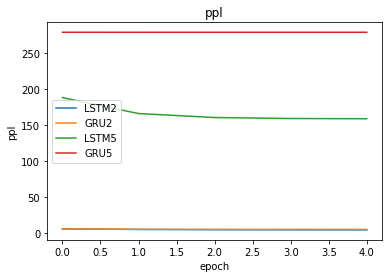

In [92]:
plot_ppl(eval_log)